# Laste inn data

Hoveddelen av koden er hentet fra koden funnet i oppgaven, eller andre koder fra githubrepositoriet til SOK-1006

Lenke til datavask :https://github.com/uit-sok-1006-v24/sok-1006_notater/blob/main/data_vask_mappe1.ipynb

Lenke til repo: https://github.com/uit-sok-1006-v24/sok-1006_notater

In [30]:
# Importerer og installerer pakker
!pip install pyjstat
!pip install pykml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import requests
from pyjstat import pyjstat
import seaborn as sns

^C


In [31]:
# Laster inn csv med data og rensker datasettet
df= pd.read_csv("eiendomsdata_2019_2023_studenter.csv")

df['BRUKSENHETSTYPEKODE'].unique()
df1 = df[df['BRUKSENHETSTYPEKODE'] == "Bolig"]

df2 = df1[df1['SALGSBELOEP'] != 0]

df_unique = df2.drop_duplicates(subset=['REGISTERENHETID', 'BRUKSENHETSID', 'SALGS_DOKUMENTAAR', 'SALGSBELOEP']).copy()

# sjekk for duplikater
duplicate_rows = df_unique[df_unique.duplicated()]

# tell antall duplikater
duplicate_rows_count = duplicate_rows.shape[0]

# Chat GPT
# Assume these are the values for the subset of columns from row 17768 (or similar rows)
values_to_check = {
    'REGISTERENHETID': 234272584,
    'BRUKSENHETSID': 61005133,
    'SALGS_DOKUMENTAAR': 2023,
    'SALGSBELOEP': 3925000
}

# Filter the DataFrame for all rows that match these values
matching_rows = df2[
    (df2['REGISTERENHETID'] == values_to_check['REGISTERENHETID']) &
    (df2['BRUKSENHETSID'] == values_to_check['BRUKSENHETSID']) &
    (df2['SALGS_DOKUMENTAAR'] == values_to_check['SALGS_DOKUMENTAAR']) &
    (df2['SALGSBELOEP'] == values_to_check['SALGSBELOEP'])
]

# Count the number of occurrences
number_of_occurrences = matching_rows.shape[0]

In [32]:
# Henter data fra SSB for å prisjustere prisene
# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/03013/"

# Spørringen og endepunktet til API-et hentes fra Statistikkbanken eller API-konsoll.
# apiQuery = # lim inn spørringen din her


apiQuery = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": [
          "TOTAL"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiIndMnd"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2019M01",
          "2019M02",
          "2019M03",
          "2019M04",
          "2019M05",
          "2019M06",
          "2019M07",
          "2019M08",
          "2019M09",
          "2019M10",
          "2019M11",
          "2019M12",
          "2020M01",
          "2020M02",
          "2020M03",
          "2020M04",
          "2020M05",
          "2020M06",
          "2020M07",
          "2020M08",
          "2020M09",
          "2020M10",
          "2020M11",
          "2020M12",
          "2021M01",
          "2021M02",
          "2021M03",
          "2021M04",
          "2021M05",
          "2021M06",
          "2021M07",
          "2021M08",
          "2021M09",
          "2021M10",
          "2021M11",
          "2021M12",
          "2022M01",
          "2022M02",
          "2022M03",
          "2022M04",
          "2022M05",
          "2022M06",
          "2022M07",
          "2022M08",
          "2022M09",
          "2022M10",
          "2022M11",
          "2022M12",
          "2023M01",
          "2023M02",
          "2023M03",
          "2023M04",
          "2023M05",
          "2023M06",
          "2023M07",
          "2023M08",
          "2023M09",
          "2023M10",
          "2023M11",
          "2023M12"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [33]:
# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds

df, df_id, ds = apiToDataframe(postUrl, apiQuery)

In [34]:
kpi_df = df

# gi nytt navn til KPI kolonne

kpi_df.rename(columns={'value': 'KPI'}, inplace=True)



# gjør måned om til samme format som i eiendomsdata mm/yyyy
kpi_df['måned'] = pd.to_datetime(kpi_df['måned'], format='%YM%m').dt.strftime('%m/%Y')
kpi_df.head()

# gjør dokumentdato om til mm/yyyy
# ny kolonne Salgsmåned
df_unique.loc[:, 'Salgsmåned'] = pd.to_datetime(df_unique['DOKUMENTDATO'], format='%d/%m/%Y').dt.strftime('%m/%Y')

# få riktig måned/år for salg tilpasset KPI fra samme måned
df_unique = df_unique.merge(kpi_df, left_on='Salgsmåned', right_on='måned', how='left')

# Nice!
# nå kan vi prisjustere
# formel: pris i 2015 NOK = SALGSBELOEP*100/KPI

df_unique['JustBeløp'] = df_unique['SALGSBELOEP'] * (100 /df_unique['KPI'])

df_unique['JustBeløp'] = df_unique['JustBeløp'].astype(int) # sikre hele tall

# trekk ut det som vi ønsker å bruke
data = df_unique[['SALGS_DOKUMENTAAR', 'SALGSBELOEP', 'BRUKSAREAL', 'POSTNUMMER', 'GATENAVN', 'ANTALLROM', 'Salgsmåned', 'JustBeløp']].copy()

# gi nye navn
data.rename(columns={'SALGS_DOKUMENTAAR': 'År', 'SALGSBELOEP': 'Beløp',
                     'BRUKSAREAL': 'Bruksareal', 'POSTNUMMER': 'Postnummer', 'GATENAVN': 'Gate', 'ANTALLROM': 'Rom',
                     'Salgsmåned': 'Måned/År', 'JustBeløp': 'Pris (fast)'}, inplace=True)
df = data

In [35]:
data.loc[:, 'Pris (1000000)'] = data['Pris (fast)'] / 1000000
data.loc[:, 'Pris (1000)'] = data['Pris (fast)'] / 1000


# beregn gjennomsnittspris per år
gj_pris_år = data.groupby('År')['Pris (1000)'].mean()

# Samfunnsøkonomisk Analyse av Boligmarkedet i Tromsø 2019-2023
Mappeoppgave 1

SOK-1006 Mikroøkonomi

Kandidatnummer: 42

## Sammendrag
Denne analysen gir et bilde av boligmarkedet i Tromsø i tiden 2019-2023. Analysen er i hovedsak basert på data fra Mediehuset iTromsø over alle boligsalg i Tromsø over perioden, med supplerende informasjon fra SSB. Jeg går igjennom den historiske bakgrunnen til det norske boligmarkedet og teorien om perfekt marked og det frie markedet som optimal distributør av ressurser.  

Kapittel 1 er en introduksjon til temaet. Her presenteres den historiske bakgrunnen for det Norske boligmarkedet, og eventuell problematikk når bolimarkedet ikke fungerer som distributør av ressurser.  

Kapittel 2 forklarer teoriene bak markedskrysset. Og hvorfor boligmarkedet aldri vil kunne være i likevekt og dermed staten må komme inn og regulere.  

Kapittel 3.1 Presenteres dataene over Tromsø. Vi ser på elastisiteten i etterspørselen, og utviklingen av boligkjøp over tid. Vi ser at det konsekvent er ulikheter i prisene i Tromsøs områder, som peker på en markedssegmentering som peker til et imperfekt marked.  

Kapittel 3.2 Presenteres potensielle løsninger på boligpriskrisen, og effekter dette kan ha på markedskrysset.

Kapittel 4 Konklusjon.

## 1. Introduksjon

Som I flere andre byer i landet har boligmarkedet i Tromsø opplevd økende boligpriser over de siste årene. Blant annet er dette bekymringsfullt fordi det begrenser tilgangen på markedet for nye eiere, som igjen er dårlig fordi de ikke får tilgang på det gunstige skattefordelene for boligeiere, skaper ugunstig segregering over områder, og holder viktig arbeidskraft utenfor byen. Der er sykepleierindeksen brukt som et verktøy for å sjekke tilgangen for en person med god fast lønn til boligmarkedet i Tromsø.

I denne analysen skal jeg gjennomføre en enkel samfunnsøkonomisk analyse av boligmarkedet i Tromsø baser på et datasett utlevert av Mediehuset iTromsø over alle eiendomstransaksjoner i Tromsø kommune i perioden 2019-2023, inkludert salgspriser, kvadratmeter, kjøpsår, og postnummer. Med utgangspunkt i teorien rundt markedskrysset og markedslikevekt skal jeg se på det dataen forteller oss om utviklingen i boligmarkedet i Tromsø og potensielle effekter av politisk innvirkninger på boligmarkedet.

I 2011 kom (NOU) 2011: 15 med tittelen "Rom for alle. En sosial boligpolitikk for framtiden". Her var et utvalg satt ned for å vurdere utfordringer og oppgaver knyttet til den sosiale boligfordelingen i tiden fremover.  Utvalget kom fra til at  
- Bolig er en viktig del av velferdspolitikken og bør, sammen med helse, utdanning, og inntektssikring, anerkjennes som en av velferdspolitikkens fire pilarer.
- Det foreslås et boligsosialt løft i kommunene, hvor kommunene gis et større handlingsrom og klarere juridiske rammer for å ivareta sitt boligsosiale ansvar.
- Boligeie bør gjøres mulig for flere enn i dag, spesielt for personer med stabil, om enn lav inntekt.
- Det private leiemarkedet bør utvikles for å bedre tilpasse seg beboernes behov, og det bør legges til rette for en nasjonal leieboerforening for å styrke leiernes muligheter til å ivareta sine rettigheter.

## 2. Teoretisk rammeverk: Boligmarkedsdynamikker, Markedskryss og Samfunnsøkonomisk Velferd

### 2.1 Perfekte Marked og relasjonen til Boligmarkedet

Boligmarkedet spiller en sentral rolle i norske husholdningers økonomi, og norsk velferdspolitikk. Samtidig er det norske boligmarkedet det mer privatisert enn boligmarkedene i resten av europa. I et mikroøkonomisk perspektiv er et perfekt kompetitivt marked den optimale måten å fordele ressursene i et samfunn da alle som har mulighet til å kjøpe innenfor deres betalingsvillighet (budsjett og villighet til å kjøpe et gode) får kjøpt.

Det perfekte marked er også karakterisert av perfekt konkurranse, komplett informasjon for alle parter, ingen transaksjonskostnader eller inngangspriser, og så mange kjøpere og selgere at ingen alene kan styre prisen på godet. Allerede ser vi at det er noen punkter som ikke matcher med boligmarkedet, men viktigst av alt er kanskje komplett homogenitet i produktet tilbydd. Siden hver bolig er unik i sin geografiske lokasjon og tilstand er det ikke mulig for boligmarkedet å oppfylle denne.

### 2.2 Likevekt Mellom Kjøpere og Selgere i Boligmarkedet

Når kvanta tilbydd og kvanta etterspurt utlignes, når man markedslikevekt som resulterer i en stabil likevektspris. Denne likevekten er grunnpillar innen effektiv allokering av ressurser i boligmarkedet, som i en ideell verden vil føre til at tilbudet av boliger møter samfunnets behov. Likevektsprisen signaliserer den faktiske verdien eller kostnaden på bolig, og er også måten vi oppnår perfekt informasjon mellom kjøpere og selgere. I et perfekt marked betyr også likevektsprisen at vi har nådd Pareto-effektivitet, som er når inget individ kan få en forbedring i dets velferd uten at det negativt påvirker en annens velferd, som er grunnsteinen i den ideelle tilstanden i samfunnsøkonomisk velferd.  

### 2.3 Boligmarkedet og Perfekt Konkurranse: En mismatch

Dessverre er det noen aspekter ved boligmarkedet som gjør det umulig å oppfylle kriteriene for perfekt marked:

- Informasjonsasymetri: Kjøpere og Selgere har ikke samme kunnskap om tilstanden på boligen, potensiell verdi i fremtiden, og andre kritiske faktorer - som fører til markedsineffektivitet.
- Høye innsattskostnader: Å kjøpe og selge bolig kommer med flere andre kostnader som skatt, selgnrproveny, og andre legale kostnader, som fjerner boligmarkedet fra det frie markedet og forvrenger markedskondisjoner.
- Immobilitet: Et perfekt marked forutsetter at kjøpere og tilbydere kan bevege seg og produktet til der prisen er mest gunstig. Dette er ikke mulig for boliger, og hver bolig er på mange måter unik. Samtidig er bolig immobilt som fører med seg geografiske begrensninger og skaper mindre lokale markeder som igjen forvrenger likheten mellom kjøpere og selgere.
- Heterogenitet: Hver bolig er på mange måter unik, dette er dermed i direkte kontrast med antakelsen i et perfekt marked om at hvert produkt er likt.

### 2.4 Samfunnsøkonomisk velferd og Boligmarkedet

Det er en uttalt politikk i norge at bolig er en sentral del av velferdssamfunnet. Boligens verdi går utover bare monetær verdi da den også representerer nærhet til institusjoner, tilgang, og likhet. I det ideelle scenariet representerer markedskrysset ikke bare den mest samfunnsøkonomisk effektive tildelingen av ressurser, men også viser til at befolkningen får dekt sine individuelle behov som igjen styrker samfunnsøkonomisk velferd.

### 2.5 Markedsfeil og deres implikasjoner for samfunnsøkonomisk velferd

Markedsfeil i boligmarkedet, inkludert monopolistiske tilfeller, eksternaliteter, og offentlige goder, har en sterk negativ effekt på samfunnsøkonomisk velferd. Noen eksempler er:

- Monopolistiske markeder: Utbyggere og de som eier flere boliger kan affektere pris og tilgjengelighet på boliger, ved å hindre tilbud og øke prisene over markedslikevekten.
- Eksternaliteter: Effekter av overkrowding, forurensning og lignende, pluss tilgangen på godt bevarte offentlige rom er ikke tatt med i boligprisen. Som kan føre til en suboptimal fordeling.
- Offentlige goder: Et markedsstyrt boligmarked vil sannsynligvis ikke fokusere på offentlige goder og behov for lavinntektsfamilier, som kan føre til en kløft mellom markedseffekten og samfunnsmessige behov.

### 2.6 Hvordan håndtere markedsfeil for å forbedre den samfunnsøkonomiske velferden

Måter å addressere markedsfeil og styrke den samfunnsøkonomiske velferden inkluderer, endinger i regulering, endring i økonomi og finansiering, og subsidier. Alle disse tiltakende vil ha en vridende effekt på et marked, men om markedet allerede ikke fungerer optimalt kan denne vridningen forbedre den samfunnsøkonomiske likevekten.

## Kapittel 3: Huspriser i Tromsø: Analyse og Potensielle Tiltak

In [43]:
!pip install tabulate
import pandas as pd
from tabulate import tabulate

# Assuming 'df' is your DataFrame and 'Beløp' is the column of interest for sale prices

# Calculate descriptive statistics
descriptive_stats = df['Beløp'].describe()

# Convert the descriptive statistics to a DataFrame for nice formatting
descriptive_stats_df = pd.DataFrame(descriptive_stats).reset_index()

# Renaming columns for clarity
descriptive_stats_df.columns = ['Statistic', 'Value']

# Formatting the 'Value' column to show numbers with commas and two decimal places
descriptive_stats_df['Value'] = descriptive_stats_df['Value'].apply(lambda x: "{:,.2f}".format(x))

# Display the table using tabulate
print(tabulate(descriptive_stats_df, headers='keys', tablefmt='pretty', showindex=False))


+-----------+---------------+
| Statistic |     Value     |
+-----------+---------------+
|   count   |   9,891.00    |
|   mean    | 3,705,472.40  |
|    std    | 1,999,528.95  |
|    min    |     1.00      |
|    25%    | 2,410,000.00  |
|    50%    | 3,350,000.00  |
|    75%    | 4,650,000.00  |
|    max    | 18,500,000.00 |
+-----------+---------------+


Tilbud og etterspørsel i boligmarkedet i Tromsø:

Etterspørsel i boligmarkedet avhenger av faktorer som: inntektsnivå, befolkningsvekst, rentenivå, og preferanser blant befolkningen. Økt inntekt eller befolkningsvekst kan øke etterspørselen etter boliger.

Tilbudet på boliger påvirkes av: tilgjengelig land, byggekostnader, reguleringer og politiske fordringer. En økning i byggekostnader (som ett under og etter COVID) eller strengere reguleringer kan redusere tilbudet av boliger.

### Del 1 - Dagens Forhold

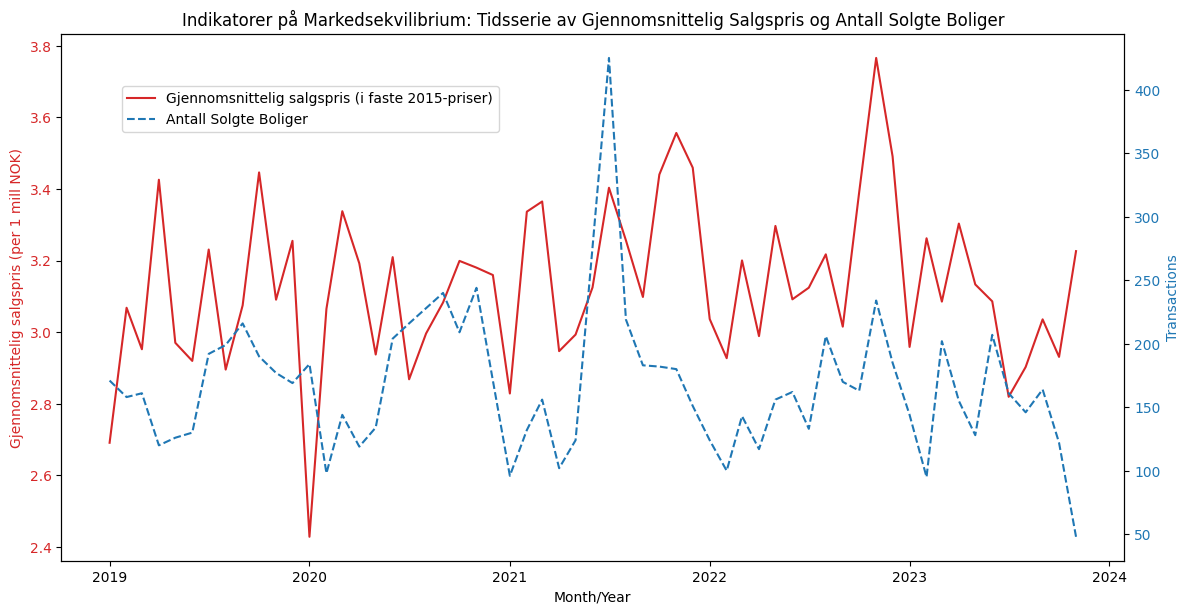

In [44]:
# Gjennomsnittelig pris og antall transaksjoner i boligmarkedet over år
df['Måned/År'] = pd.to_datetime(df['Måned/År'], format='%m/%Y')

# Aggregate data by Month/Year for average sale price and transaction count
plot_data = df.groupby(df['Måned/År']).agg(
    Average_Sale_Price=('Pris (1000000)', 'mean'),
    Transactions=('Pris (1000000)', 'count')
).reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Month/Year')
ax1.set_ylabel('Gjennomsnittelig salgspris (per 1 mill NOK)', color=color)
ax1.plot(plot_data['Måned/År'], plot_data['Average_Sale_Price'], color=color, label='Gjennomsnittelig salgspris (i faste 2015-priser)')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the number of transactions
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Transactions', color=color)
ax2.plot(plot_data['Måned/År'], plot_data['Transactions'], color=color, linestyle='--', label='Antall Solgte Boliger')
ax2.tick_params(axis='y', labelcolor=color)

# Adding title and legend
fig.tight_layout()
plt.title('Indikatorer på Markedsekvilibrium: Tidsserie av Gjennomsnittelig Salgspris og Antall Solgte Boliger')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()


Figur 1 – en oversikt over gjennomsnittelige prisendringer i Tromsø 2019-2023, med antall solgte boliger på den venstre y-aksen. Antall salg på den høyre y-aksen og dato på x-aksen. Denne oversikten viser oss om markedet i Tromsø følger ideene bak marked og elastisitet.

Elastisitet er et mål på hvor mange som vil velge bort en vare om den varen går opp i pris med 1%. Teorien tilsier at om et marked er inelastisk på etterspørselssiden, så vil det likevel selges like mange boliger. På den andre siden om et marked er elastisk, kan man også si at det er prissensitivt – og det vil være mindre salg jo høyere prisen er.

Vi ser på denne grafen at markedet i Tromsø ikke er spesielt elastisk, da transaksjonene ikke virker å ha en markant effekt av økte priser før tidrommet 2023-2024 som er mer i tråd med vanlige ideer om elastisitet. Dette er i tråd med hvilken type gode bolig er, da det er et nødvendig gode og det dermed ikke er et valg å velge det vekk. Kombiner det med et privat leiemarked med varierende kvalitet er det ikke rart å forvente at boligmarkedet er relativt uelastisk.

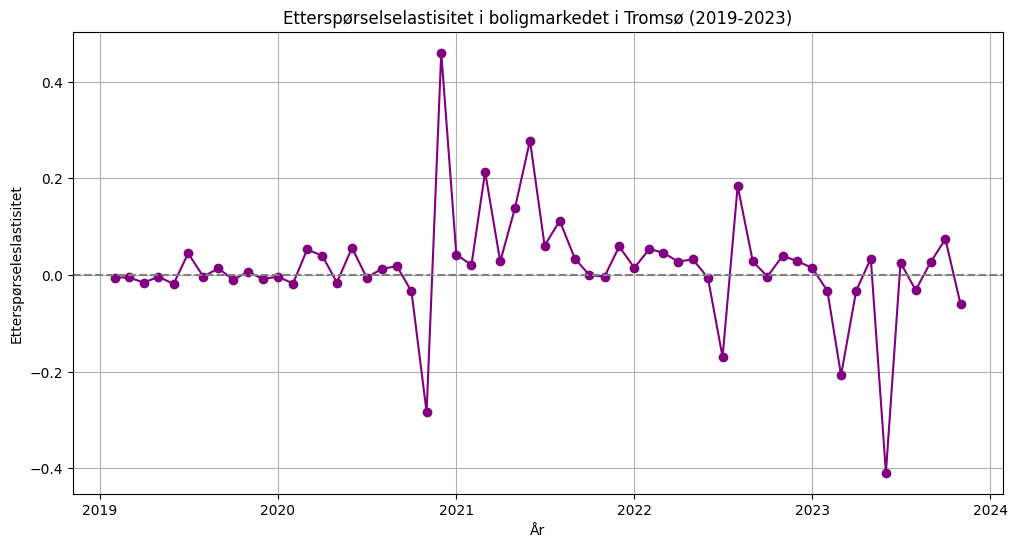

In [39]:
# Etterspørselselastisitet i boligmarkedet i Tromsø

df['Måned/År'] = pd.to_datetime(df['Måned/År'], format='%m/%Y')

# Calculating the percentage change in average sale price and number of transactions over time
elasticity_data = df.groupby(df['Måned/År']).agg(
    Average_Sale_Price=('Pris (fast)', 'mean'),
    Transactions=('Pris (fast)', 'count')
).reset_index()
elasticity_data['Price_Change'] = elasticity_data['Average_Sale_Price'].pct_change() * 100
elasticity_data['Transactions_Change'] = elasticity_data['Transactions'].pct_change() * 100

# Calculating a simplified measure of demand elasticity
elasticity_data['Demand_Elasticity'] = (elasticity_data['Transactions_Change'] / elasticity_data['Price_Change']) / 100
elasticity_data = elasticity_data.replace([np.inf, -np.inf], np.nan).dropna()

# Plotting the inferred elasticity of demand over time
plt.figure(figsize=(12, 6))
plt.plot(elasticity_data['Måned/År'], elasticity_data['Demand_Elasticity'], marker='o', linestyle='-', color='purple')
plt.title('Etterspørselselastisitet i boligmarkedet i Tromsø (2019-2023)')
plt.xlabel('År')
plt.ylabel('Etterspørseleslastisitet')
plt.axhline(0, color='gray', linestyle='--')  # Reference line for no change
plt.grid(True)
plt.show()


Figur 2 – Etterspørselselastisiteten etter boliger.

Her har jeg prøvd å lage en egen graf for elastisiteten i boligmarkedet. Som vi så i den forrige grafen virker ikke transaksjonene å være veldig affektert av høyere boligpriser. Ihvertfall ikke negativt. Derimot kan det se ut som om elastisiteten i boligmarkedet i Tromsø til tider har vært spesielt inelastisk, og da markant i tidsrommet 2021-2022 (illustrert ved atlinjen ligger over 0).

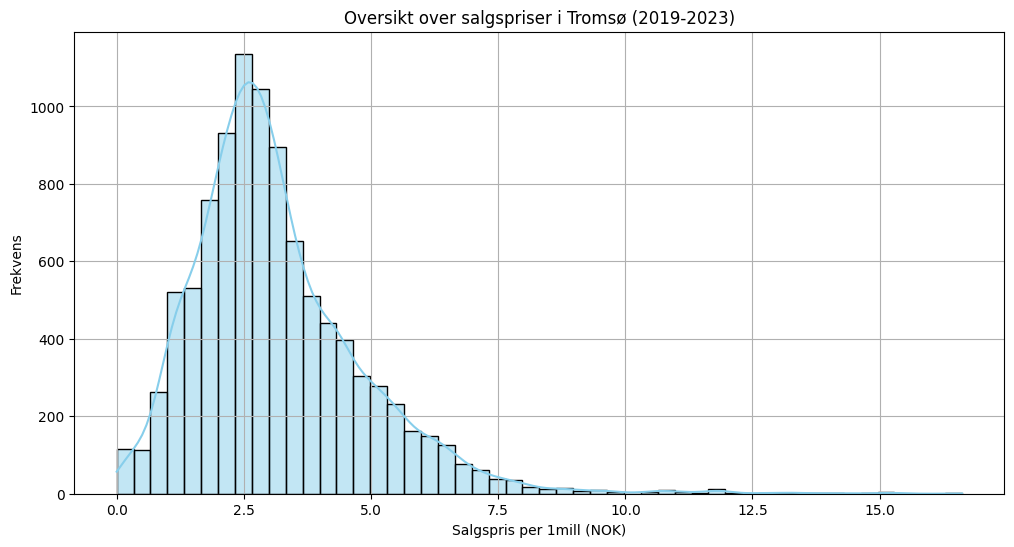

In [45]:


# Assuming df is your DataFrame and 'Beløp' is the column for sale prices

# Creating the histogram of sale prices
plt.figure(figsize=(12, 6))
sns.histplot(df['Pris (1000000)'], bins=50, kde=True, color='skyblue')
plt.title('Oversikt over salgspriser i Tromsø (2019-2023)')
plt.xlabel('Salgspris per 1mill (NOK)')
plt.ylabel('Frekvens')
plt.grid(True)
plt.show()


Figur 3 – Prisen boliger er solgt til i perioden

Som vi ser av figur 3, og som er korroborert av den diskrete analysen av data tidligere i dokumentet, ligger prisen på boliger kjøpt i Tromsø på rundt 2.5 - 3 millioner kroner i gjennomsnitt. I følge eiendomnorge kunne en sykepleier med normal lønne i 2023 maks få et lån på 3.170.000 kr og dermed kjøpe omtrent 20.8% av boligene i byen.  

### Del 2: Analyse av Tiltak for Reduserte Boligpriser

Utredningen NOU 2011:15 fokuserte på noen tiltak for å forbedre den samfunnsøkonomiske fordelingen av boliger i Norge. Noen av dem var:

Startlån og tilskudd

Startlån er et viktig virkemiddel for å hjelpe personer som av ulike årsaker ikke får lån i den ordinære banken til å kjøpe egen bolig. Startlån kan også benyttes til refinansiering for å beholde en bolig. Dette lånet er spesielt rettet mot de som står utenfor det ordinære boligmarkedet, inkludert lavinntektsfamilier, aleneforsørgere, og personer med særskilte sosiale eller helsemessige utfordringer.

Tilskudd til etablering kan gis til personer som trenger økonomisk støtte for å etablere seg i egen bolig. Dette kan være i form av tilskudd til kjøp av bolig eller tilpasning av bolig til personer med nedsatt funksjonsevne.

Potensiell markedseffekt: Startlån og tilskudd til etablering kan gjøre det mulig for de utenfor markedet å komme seg inn på boligmarkedet, men om det ikke matches av en høyere tilgang på boliger kan det føre til enda høyere boligpriser. Dette er reflektert i teoriene om markedskrysset der en økning i etterspørsel (om tilgangen på boliger holdes konstant) vil lede til høyere priser.



Boligtilskudd  

Dette tilskuddet er rettet mot kommuner og andre aktører som skal etablere boliger for personer som ikke selv kan ivareta sine interesser i boligmarkedet. Målet er å øke tilbudet av tilpassede og rimelige utleieboliger for de mest utsatte gruppene.

Potensiell markedseffekt: Boligtilskudd kan direkte affektere etterspørselssiden på boligmarkedet. Så lenge tilgangen på adnre boliger er lik burde dette dempe presset i boligmarkedet og dermed potensielt føre til lavere priser, men dette er kun om disse tilskuddene ikke går på bekostning av de som allerede konstruerer boliger. For om det vil erstatte boliger som bygges kan dette igjen føre til økt etterspørsel i forhold til tilbud.

In [47]:
# Kode hentet fra SOK-1006 githubrepositoriet, for å illustrere markedslikevekt
import sympy as sp
# Definer variabler og parametre
x, p, a, b, A, B, t = sp.symbols('x p a b A B t')

# faktiske verdier
x_value = 187000
p_value = 1000
t_value = 0.12

# likninger for etterspørsel og tilbud
eq_d = sp.Eq(x, a - b * p)
eq_s = sp.Eq(x, -A + B * p * (1 - t))

# sett inn verdiene for a,p,t
eq_d_sub = eq_d.subs({x: x_value, p: p_value})
eq_s_sub = eq_s.subs({x: x_value, p: p_value, t: t_value})

# løs likningssystem
sol = sp.solve((eq_d_sub, eq_s_sub), (a, b, A, B))

sol

# 2.
# likninger for etterspørsel og tilbud uten mva
eq_d_umva = sp.Eq(x, 287 - 0.1 * p)
eq_s_umva = sp.Eq(x, -33 + 0.25 * p)



# løs likningssystem
sol_umva = sp.solve((eq_d_umva, eq_s_umva), (p,x))

p_num=np.linspace(0.1,1500,100)
# Økt bygging

def tilbud(p):
    return -20 + 1.5*p

#lag en akse som vi skal bruke flere ganger

def create_ax():
                fig, ax = plt.subplots()
                ax.set_ylabel('Pris (p)', loc='top')
                ax.set_xlabel('Kvantum (x)', loc='right')
                ax.set(xlim=(0,110))
                ax.set(ylim=(0,110))
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')

                return fig, ax

#fig, ax = create_ax()

# plott funksjonen

ax.plot(tilbud(p_num),p_num, label='tilbud')

#vis navnene:
ax.legend(loc='best',frameon=False);

def etters(p):
    return 100 - 1.25*p

#fig, ax = create_ax()

ax.plot(tilbud(p_num), p_num ,label='tilbud')
ax.plot(etters(p_num), p_num ,label='etterspørsel')


ax.legend(loc='best', frameon=False);

def tilbud_ny(p):
    return -5+1.5*p

#fig, ax = create_ax()


ax.plot(tilbud(p_num), p_num ,label='tilbud')
ax.plot(tilbud_ny(p_num), p_num ,label='nytt tilbud', linestyle = 'dashed', color = 'black')
ax.plot(etters(p_num), p_num ,label='etterspørsel')

ax.set_title('Markedslikevekt med økt tilbud')

ax.legend(loc='best', frameon=False);

# tegne løsningen i figuren

ax.plot ([150,sol_umva[x]], [sol_umva[p], sol_umva[p]], linestyle='dashed', color='black')
ax.plot ([sol_umva[x], sol_umva[x]], [500, sol_umva[p]], linestyle='dashed', color='black')

ax.legend(bbox_to_anchor=(1.5,0.6))

fig


{p: 914.285714285714, x: 195.571428571429}

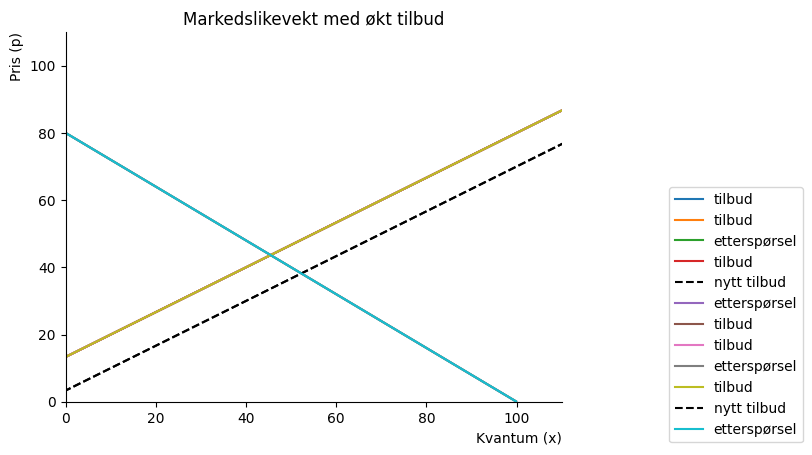

## Kapittel 4: Avslutning

Gjennom å bruke teorien rundt perfekte marked som lupe har jeg prøvd å få innblikk i faktorene som driver dynamikken i prisene i Tromsøs boligmarked. Jeg har sett at boligmarkedet i Tromsø er relativt inelastisk, som indikerer et høyere behov for boliger enn det som for øyeblikket er tilgjengelig. Jeg har også sett på et par potensielle bøtemidler av NOU 2011:15 og sett hvordan disse kan ha en potensielt positiv effekt på markedet så lange det ikke fører til en nedgang i boliger tilgjengelig.

# Appendix

## Kilder

Hoveddelen av koden er hentet fra koden funnet i oppgaven, eller andre koder fra githubrepositoriet til SOK-1006

Lenke til datavask :https://github.com/uit-sok-1006-v24/sok-1006_notater/blob/main/data_vask_mappe1.ipynb

Lenke til repo: https://github.com/uit-sok-1006-v24/sok-1006_notater

Gitmark, Hannah. "Omvendt Robin Hood-Politikk i Boligmarkedet Øker Forskjellene Mellom Folk." Tidsskrift for Boligforskning, vol. 4, nr. 1, 2021, s. 63–74. Idunn.no, https://doi.org/10.18261/issn.2535-5988-2021-01-05.

Norge. Kommunal- og regionaldepartementet. "Rom for alle. En sosial boligpolitikk for framtiden." Norges offentlige utredninger, NOU 2011: 15, Kommunal- og regionaldepartementet, 2011.

## Bruk av KI

KI er blitt brukt til å hjelpe å lage penere grafer ved at jeg gir den en veldig simpel kode for å lage en graf, og så ber den om å forbedre grafen.

Ex:

data.set_index('Måned/År')['Pris (1000000)'].resample('M').mean().plot()
plt.title('Gjennomsnittelig salgspris over tid')
plt.xlabel('Dato')
plt.ylabel('Gjennomsnittelig salgspris (NOK)')
plt.show()


Og ber den om å gjøre den bedre, etter å ha beskrevet datasettet.



## Lenke til github-repositorie med kode

https://github.com/osa032/SOK-1006